<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/data_preprocessing/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDC(Golden Dead Cross)

In [ ]:
!pip install backtrader

     |████████████████████████████████| 410 kB 12.7 MB/s 


In [ ]:
pip install finance-datareader

In [ ]:
pip install backtesting

     |████████████████████████████████| 174 kB 9.8 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.2-py3-none-any.whl size=173671 sha256=cfb52700e88dac67c2c5f37b39012c202bd14327e358456163dfff631801399a
  Stored in directory: /root/.cache/pip/wheels/22/0e/30/e458272563bdbea1905391b5bb5702e2001a769544d9cb2df3
Successfully built backtesting


In [ ]:
pip install deap

     |████████████████████████████████| 160 kB 10.4 MB/s 


In [ ]:
import re
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date, timedelta
from google.colab import drive
import backtrader as bt
from IPython.display import display, Image
import backtrader.feeds as btfeeds
from backtesting import Strategy
from backtesting import Backtest
from deap import base, creator, tools, algorithms
import random
import seaborn as sns
from tqdm import trange
import time

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/[Shared]K-Project/data/'

Mounted at /content/drive


In [ ]:
## Load pickle - fullcode 목록
with open(data_path + 'full_code.pkl',"rb") as f: 
    fullcode = pickle.load(f)
    
# 상장폐지 상태 제외시키기
fullcode_filter = fullcode[fullcode['status'] != '상장폐지']

# fullcode열을 list로 변경
fullcode_list = list(fullcode_filter['full_code'])
print(fullcode_list[:10])
print(len(fullcode_list))

['KR7060310000', 'KR7095570008', 'KR7006840003', 'KR7054620000', 'KR7265520007', 'KR7211270004', 'KR7027410000', 'KR7282330000', 'KR7138930003', 'KR7001460005']
2606


In [ ]:
with open(data_path + 'initial_data1.json',"r") as json_file:
    json_data = json.load(json_file) 

In [ ]:
# 시가총액 상위 10개 종목 구하기

key_list = list(json_data.keys())
mktcap_dict = {}

for i in range(len(fullcode_list)): 

    if fullcode_list[i] in key_list: # 어제 있던 데이터가 오늘도 정상적으로 있는 경우
        df = pd.read_json(json_data[fullcode_list[i]], orient = 'index') # 첫번째 키값으로 데이터프레임 변환
        json_df = df.transpose()
        
        try:
            mktcap = json_df.iloc[0,7] # 수집된 데이터의 마지막 날짜 확인
            mktcap = int(re.sub(',', '', mktcap))
            mktcap_dict[fullcode_list[i]] = mktcap
            print(i)

        except:
            print(i, 'except문 작동', fullcode_list[i])

    else:
        print(i, '신규상장', fullcode_list[i])

sorted_dict = sorted(mktcap_dict.items(), key = lambda item: item[1], reverse = True)
mktcap_top10 = sorted_dict[:10]

mktcap_code = []

for i in range(len(mktcap_top10)):
    mktcap_code.append(mktcap_top10[i][0])

print(mktcap_code)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
mktcap_code = ['KR7005930003', 'KR7000660001', 'KR7035420009', 'KR7207940008', 'KR7005931001', 'KR7035720002', 'KR7051910008', 'KR7006400006', 'KR7005380001', 'KR7000270009']
mktcap_code

['KR7005930003',
 'KR7000660001',
 'KR7035420009',
 'KR7207940008',
 'KR7005931001',
 'KR7035720002',
 'KR7051910008',
 'KR7006400006',
 'KR7005380001',
 'KR7000270009']

In [ ]:
for i in mktcap_code:  
  
  # backtest 데이터 가공

  data = pd.read_json(json_data[i], orient ='index') 
  df = data.transpose()

  #시간순 재정렬
  df = df.sort_values(by=['TRD_DD'])
  df.reset_index(drop=True,inplace=True)
  df['TRD_DD'] = pd.to_datetime(df['TRD_DD']) #datetime변환

  #인풋 데이터 모양 맞춰주기(backtest에 들어갈 데이터 모양)
  df_bt = df[['TRD_DD','TDD_OPNPRC','TDD_HGPRC','TDD_LWPRC','TDD_CLSPRC', 'ACC_TRDVOL']]
  df_bt['TRD_DD'] = pd.to_datetime(df_bt['TRD_DD'])
  df_bt.rename(columns={'TRD_DD':'Date', 'TDD_OPNPRC':'Open', 'TDD_HGPRC':'High','TDD_LWPRC':'Low','TDD_CLSPRC':'Close', 'ACC_TRDVOL':'Volume'}, inplace=True)
  df_bt.set_index('Date',drop=True,inplace=True)

  #데이터프레임 콤마(,) 제거 그리고 타입 소수로 변환
  df_bt['Open'] = df_bt['Open'].str.replace(',','').astype('float')
  df_bt['High'] = df_bt['High'].str.replace(',','').astype('float')
  df_bt['Low'] = df_bt['Low'].str.replace(',','').astype('float')
  df_bt['Close'] = df_bt['Close'].str.replace(',','').astype('float')
  df_bt['Volume'] = df_bt['Volume'].str.replace(',','').astype('float')

  class SmaCross1(bt.Strategy):
    params = dict(
      pfast=50, # period for the fast moving average
      pslow=200 # period for the slow moving average 
      ) 
    
    def __init__(self):
      sma1 = bt.ind.SMA(period = self.p.pfast) # fast moving average 
      sma2 = bt.ind.SMA(period = self.p.pslow) # slow moving average 
      self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 

    def next(self): 
      if not self.position: # not in the market 
        if self.crossover > 0: # if fast crosses slow to the upside 
          close = self.data.close[0] # 종가 값 
            
          size = int(self.broker.getcash() / close) # 최대 구매 가능 개수 
          self.buy(size=size) # 매수 size = 구매 개수 설정 
      elif self.crossover < 0: # in the market & cross to the downside 
          self.close() # 매도
          
  # 세레브로 (벡트레이더 엔진) 설정

  # 세레브로 가져오기
  cerebro = bt.Cerebro()

  # 데이터 가져오기
  data = bt.feeds.PandasData(dataname=df_bt,name="SAMSUNG")


  # 데이터 추가하기
  cerebro.adddata(data)

  # 전략 추가하기
  cerebro.addstrategy(SmaCross1)

  # 브로커 설정
  cerebro.broker.setcash (1000000)

  # 매매 단위 설정
  cerebro.addsizer(bt.sizers.SizerFix, stake = 30) #한번에 30주 설정.

  # 3. 세레브로 실행하기

  # 초기 투자금 가져오기
  init_cash = cerebro.broker.getvalue()

  # 세레브로 실행하기
  cerebro.run()

  # 최종 금액 가져오기
  final_cash = cerebro.broker.getvalue()

  print(i)
  print("최종금액 : ", final_cash, "원")
  print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")
  print("\n")

KR7005930003
최종금액 :  1369350.0 원
수익률 :  36.935 %


KR7000660001
최종금액 :  1452130.0 원
수익률 :  45.213 %


KR7035420009
최종금액 :  15640500.0 원
수익률 :  1464.05 %


KR7207940008
최종금액 :  55000.0 원
수익률 :  -94.5 %


KR7005931001
최종금액 :  37760850.0 원
수익률 :  3676.0849999999996 %


KR7035720002
최종금액 :  1524800.0 원
수익률 :  52.480000000000004 %


KR7051910008
최종금액 :  2786300.0 원
수익률 :  178.63 %


KR7006400006
최종금액 :  2086400.0 원
수익률 :  108.64 %


KR7005380001
최종금액 :  1592450.0 원
수익률 :  59.245000000000005 %


KR7000270009
최종금액 :  95581050.0 원
수익률 :  9458.105 %




KR7005930003


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:25<17:43, 265.89s/it]

HALL OF FAME:
  0: [28, 129], Fitness: 2.9224001954215524
  1: [44, 238], Fitness: 2.6157614461194862
  2: [52, 156], Fitness: 2.286056377863675


 40%|████      | 2/5 [07:12<10:21, 207.24s/it]

HALL OF FAME:
  0: [44, 129], Fitness: 3.3223409564227664
  1: [35, 120], Fitness: 3.2742751092246887
  2: [50, 123], Fitness: 3.2472937763822753


 60%|██████    | 3/5 [09:56<06:15, 187.54s/it]

HALL OF FAME:
  0: [26, 129], Fitness: 4.482500069825293
  1: [35, 129], Fitness: 3.52497860318936
  2: [44, 129], Fitness: 3.3223409564227664


 80%|████████  | 4/5 [13:03<03:07, 187.47s/it]

HALL OF FAME:
  0: [26, 129], Fitness: 4.482500069825293
  1: [20, 129], Fitness: 3.8545397662732714
  2: [35, 129], Fitness: 3.52497860318936


100%|██████████| 5/5 [15:45<00:00, 189.01s/it]

HALL OF FAME:
  0: [26, 129], Fitness: 4.482500069825293
  1: [20, 129], Fitness: 3.8545397662732714
  2: [24, 156], Fitness: 3.726386378609074
Time Elapsed: 945.04
---------------------------------------------------------------------
KR7005930003
{'pfast': 26, 'pslow': 129}
---------------------------------------------------------------------
KR7000660001



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:01<16:04, 241.18s/it]

HALL OF FAME:
  0: [20, 153], Fitness: 3.6264462453728186
  1: [71, 211], Fitness: 2.4483020309559924
  2: [72, 164], Fitness: 2.29352729519774


 40%|████      | 2/5 [06:33<09:27, 189.09s/it]

HALL OF FAME:
  0: [20, 153], Fitness: 3.6264462453728186
  1: [71, 156], Fitness: 2.4595779210758377
  2: [71, 211], Fitness: 2.4483020309559924


 60%|██████    | 3/5 [08:59<05:38, 169.36s/it]

HALL OF FAME:
  0: [20, 153], Fitness: 3.6264462453728186
  1: [71, 156], Fitness: 2.4595779210758377
  2: [71, 211], Fitness: 2.4483020309559924


 80%|████████  | 4/5 [11:45<02:48, 168.10s/it]

HALL OF FAME:
  0: [20, 153], Fitness: 3.6264462453728186
  1: [45, 153], Fitness: 2.8846390398550725
  2: [71, 156], Fitness: 2.4595779210758377


100%|██████████| 5/5 [14:08<00:00, 169.79s/it]

HALL OF FAME:
  0: [20, 153], Fitness: 3.6264462453728186
  1: [45, 153], Fitness: 2.8846390398550725
  2: [71, 156], Fitness: 2.4595779210758377
Time Elapsed: 848.95
---------------------------------------------------------------------
KR7000660001
{'pfast': 20, 'pslow': 153}
---------------------------------------------------------------------
KR7035420009



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [02:58<11:53, 178.37s/it]

HALL OF FAME:
  0: [99, 29], Fitness: 7.470855307826406
  1: [142, 181], Fitness: 4.4855632264882
  2: [44, 191], Fitness: 4.466772224781207


 40%|████      | 2/5 [04:49<06:57, 139.00s/it]

HALL OF FAME:
  0: [99, 29], Fitness: 7.470855307826406
  1: [142, 181], Fitness: 4.4855632264882
  2: [44, 191], Fitness: 4.466772224781207


 60%|██████    | 3/5 [06:39<04:11, 125.82s/it]

HALL OF FAME:
  0: [99, 29], Fitness: 7.470855307826406
  1: [142, 181], Fitness: 4.4855632264882
  2: [35, 219], Fitness: 4.476776788528206


 80%|████████  | 4/5 [08:45<02:05, 125.80s/it]

HALL OF FAME:
  0: [99, 29], Fitness: 7.470855307826406
  1: [142, 181], Fitness: 4.4855632264882
  2: [35, 219], Fitness: 4.476776788528206


100%|██████████| 5/5 [10:33<00:00, 126.80s/it]

HALL OF FAME:
  0: [99, 29], Fitness: 7.470855307826406
  1: [50, 191], Fitness: 4.489429679103332
  2: [142, 181], Fitness: 4.4855632264882
Time Elapsed: 634.00
---------------------------------------------------------------------
KR7035420009
{'pfast': 99, 'pslow': 29}
---------------------------------------------------------------------
KR7207940008



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [00:46<03:04, 46.03s/it]

HALL OF FAME:
  0: [88, 153], Fitness: 3.190610859728507
  1: [89, 156], Fitness: 3.0721182126696833
  2: [95, 152], Fitness: 3.004819004524887


 40%|████      | 2/5 [01:15<01:48, 36.15s/it]

HALL OF FAME:
  0: [88, 153], Fitness: 3.190610859728507
  1: [90, 152], Fitness: 3.1588574660633486
  2: [89, 156], Fitness: 3.0721182126696833


 60%|██████    | 3/5 [01:44<01:05, 32.83s/it]

HALL OF FAME:
  0: [89, 73], Fitness: 5.2774236641221375
  1: [89, 152], Fitness: 3.2898868778280543
  2: [88, 153], Fitness: 3.190610859728507


 80%|████████  | 4/5 [02:17<00:32, 32.87s/it]

HALL OF FAME:
  0: [89, 73], Fitness: 5.2774236641221375
  1: [122, 45], Fitness: 4.262113187954309
  2: [89, 152], Fitness: 3.2898868778280543


100%|██████████| 5/5 [02:45<00:00, 33.11s/it]

HALL OF FAME:
  0: [89, 73], Fitness: 5.2774236641221375
  1: [122, 45], Fitness: 4.262113187954309
  2: [89, 152], Fitness: 3.2898868778280543
Time Elapsed: 165.55
---------------------------------------------------------------------
KR7207940008
{'pfast': 89, 'pslow': 73}
---------------------------------------------------------------------
KR7005931001



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:13<16:52, 253.12s/it]

HALL OF FAME:
  0: [69, 213], Fitness: 4.968492335465868
  1: [95, 155], Fitness: 4.086128690637563
  2: [95, 152], Fitness: 3.85828336053996


 40%|████      | 2/5 [06:50<09:50, 196.89s/it]

HALL OF FAME:
  0: [69, 213], Fitness: 4.968492335465868
  1: [95, 155], Fitness: 4.086128690637563
  2: [95, 153], Fitness: 4.0318353745264135


 60%|██████    | 3/5 [09:25<05:55, 177.64s/it]

HALL OF FAME:
  0: [69, 213], Fitness: 4.968492335465868
  1: [95, 155], Fitness: 4.086128690637563
  2: [95, 153], Fitness: 4.0318353745264135


 80%|████████  | 4/5 [12:22<02:57, 177.45s/it]

HALL OF FAME:
  0: [71, 204], Fitness: 5.139342754419407
  1: [69, 213], Fitness: 4.968492335465868
  2: [95, 155], Fitness: 4.086128690637563


100%|██████████| 5/5 [14:56<00:00, 179.21s/it]

HALL OF FAME:
  0: [71, 204], Fitness: 5.139342754419407
  1: [69, 213], Fitness: 4.968492335465868
  2: [95, 155], Fitness: 4.086128690637563
Time Elapsed: 896.07
---------------------------------------------------------------------
KR7005931001
{'pfast': 71, 'pslow': 204}
---------------------------------------------------------------------
KR7035720002



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [03:23<13:32, 203.10s/it]

HALL OF FAME:
  0: [75, 159], Fitness: 2.8826755747885837
  1: [78, 152], Fitness: 2.6192256540697674
  2: [90, 171], Fitness: 2.418776868181373


 40%|████      | 2/5 [05:31<07:57, 159.06s/it]

HALL OF FAME:
  0: [75, 159], Fitness: 2.8826755747885837
  1: [78, 152], Fitness: 2.6192256540697674
  2: [90, 171], Fitness: 2.418776868181373


 60%|██████    | 3/5 [07:38<04:48, 144.35s/it]

HALL OF FAME:
  0: [75, 159], Fitness: 2.8826755747885837
  1: [78, 152], Fitness: 2.6192256540697674
  2: [90, 171], Fitness: 2.418776868181373


 80%|████████  | 4/5 [10:01<02:24, 144.10s/it]

HALL OF FAME:
  0: [75, 159], Fitness: 2.8826755747885837
  1: [78, 152], Fitness: 2.6192256540697674
  2: [90, 171], Fitness: 2.418776868181373


100%|██████████| 5/5 [12:05<00:00, 145.08s/it]

HALL OF FAME:
  0: [75, 159], Fitness: 2.8826755747885837
  1: [78, 152], Fitness: 2.6192256540697674
  2: [90, 171], Fitness: 2.418776868181373
Time Elapsed: 725.42
---------------------------------------------------------------------
KR7035720002
{'pfast': 75, 'pslow': 159}
---------------------------------------------------------------------
KR7051910008



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [03:11<12:46, 191.58s/it]

HALL OF FAME:
  0: [142, 181], Fitness: 1.898126439261204
  1: [71, 13], Fitness: 1.5871721382316573
  2: [34, 217], Fitness: 1.421480556831944


 40%|████      | 2/5 [05:12<07:29, 149.96s/it]

HALL OF FAME:
  0: [150, 125], Fitness: 3.428188929738562
  1: [52, 82], Fitness: 2.683977698096649
  2: [41, 85], Fitness: 1.9313195826138645


 60%|██████    | 3/5 [07:15<04:35, 137.74s/it]

HALL OF FAME:
  0: [150, 125], Fitness: 3.428188929738562
  1: [142, 123], Fitness: 3.1504508313016486
  2: [8, 6], Fitness: 2.991942444523972


 80%|████████  | 4/5 [09:35<02:18, 138.40s/it]

HALL OF FAME:
  0: [150, 125], Fitness: 3.428188929738562
  1: [34, 90], Fitness: 3.2110533746556476
  2: [45, 85], Fitness: 3.152245515354211


100%|██████████| 5/5 [11:36<00:00, 139.20s/it]

HALL OF FAME:
  0: [150, 136], Fitness: 3.9613350074404763
  1: [150, 125], Fitness: 3.428188929738562
  2: [150, 123], Fitness: 3.327808976715686
Time Elapsed: 696.01
---------------------------------------------------------------------
KR7051910008
{'pfast': 150, 'pslow': 136}
---------------------------------------------------------------------
KR7006400006



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:16<17:06, 256.68s/it]

HALL OF FAME:
  0: [45, 219], Fitness: 1.900238566647093
  1: [99, 29], Fitness: 1.8008118308035208
  2: [1, 60], Fitness: 1.5397542030788747


 40%|████      | 2/5 [06:56<09:59, 199.94s/it]

HALL OF FAME:
  0: [150, 125], Fitness: 4.708320939074734
  1: [55, 85], Fitness: 2.5479621355885995
  2: [45, 219], Fitness: 1.900238566647093


 60%|██████    | 3/5 [09:35<06:02, 181.04s/it]

HALL OF FAME:
  0: [150, 85], Fitness: 5.937413671875
  1: [150, 125], Fitness: 4.708320939074734
  2: [128, 120], Fitness: 3.105222851178161


 80%|████████  | 4/5 [12:36<03:01, 181.17s/it]

HALL OF FAME:
  0: [150, 85], Fitness: 5.937413671875
  1: [150, 125], Fitness: 4.708320939074734
  2: [128, 81], Fitness: 4.181941597373415


100%|██████████| 5/5 [15:12<00:00, 182.57s/it]

HALL OF FAME:
  0: [150, 85], Fitness: 5.937413671875
  1: [150, 29], Fitness: 5.598266728981771
  2: [150, 125], Fitness: 4.708320939074734
Time Elapsed: 912.88
---------------------------------------------------------------------
KR7006400006
{'pfast': 150, 'pslow': 85}
---------------------------------------------------------------------
KR7005380001



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:13<16:54, 253.74s/it]

HALL OF FAME:
  0: [100, 154], Fitness: 2.828625268817204
  1: [89, 156], Fitness: 2.485050235215054
  2: [71, 152], Fitness: 2.417330495818399


 40%|████      | 2/5 [06:52<09:53, 197.85s/it]

HALL OF FAME:
  0: [100, 154], Fitness: 2.828625268817204
  1: [71, 120], Fitness: 2.539352426347255
  2: [89, 156], Fitness: 2.485050235215054


 60%|██████    | 3/5 [09:31<06:00, 180.19s/it]

HALL OF FAME:
  0: [100, 152], Fitness: 3.139450452101662
  1: [44, 154], Fitness: 2.8837600806451613
  2: [100, 154], Fitness: 2.828625268817204


 80%|████████  | 4/5 [12:33<03:00, 180.81s/it]

HALL OF FAME:
  0: [100, 152], Fitness: 3.139450452101662
  1: [44, 154], Fitness: 2.8837600806451613
  2: [100, 154], Fitness: 2.828625268817204


100%|██████████| 5/5 [15:10<00:00, 182.05s/it]

HALL OF FAME:
  0: [100, 152], Fitness: 3.139450452101662
  1: [44, 154], Fitness: 2.8837600806451613
  2: [100, 154], Fitness: 2.828625268817204
Time Elapsed: 910.27
---------------------------------------------------------------------
KR7005380001
{'pfast': 100, 'pslow': 152}
---------------------------------------------------------------------
KR7000270009



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:09<16:39, 249.91s/it]

HALL OF FAME:
  0: [71, 211], Fitness: 3.0928748802777557
  1: [75, 203], Fitness: 2.9037864521424126
  2: [89, 156], Fitness: 2.8684240258533737


 40%|████      | 2/5 [06:46<09:45, 195.22s/it]

HALL OF FAME:
  0: [71, 211], Fitness: 3.0928748802777557
  1: [48, 211], Fitness: 2.929766053129873
  2: [99, 153], Fitness: 2.925581945224281


 60%|██████    | 3/5 [09:21<05:53, 176.81s/it]

HALL OF FAME:
  0: [71, 211], Fitness: 3.0928748802777557
  1: [48, 211], Fitness: 2.929766053129873
  2: [99, 153], Fitness: 2.925581945224281


 80%|████████  | 4/5 [12:18<02:56, 176.85s/it]

HALL OF FAME:
  0: [71, 211], Fitness: 3.0928748802777557
  1: [64, 211], Fitness: 2.949463424355496
  2: [48, 211], Fitness: 2.929766053129873


100%|██████████| 5/5 [14:50<00:00, 178.08s/it]

HALL OF FAME:
  0: [71, 211], Fitness: 3.0928748802777557
  1: [64, 211], Fitness: 2.949463424355496
  2: [48, 211], Fitness: 2.929766053129873
Time Elapsed: 890.42
---------------------------------------------------------------------
KR7000270009
{'pfast': 71, 'pslow': 211}
---------------------------------------------------------------------


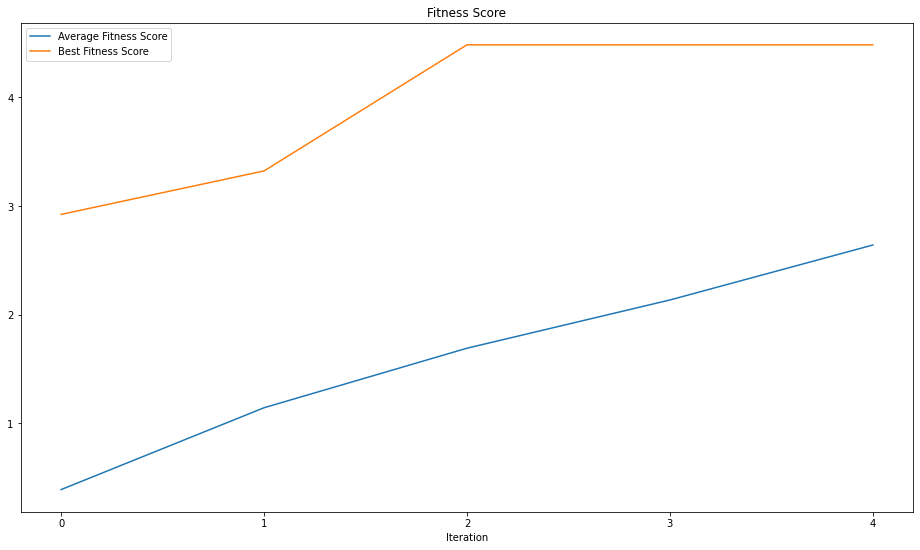

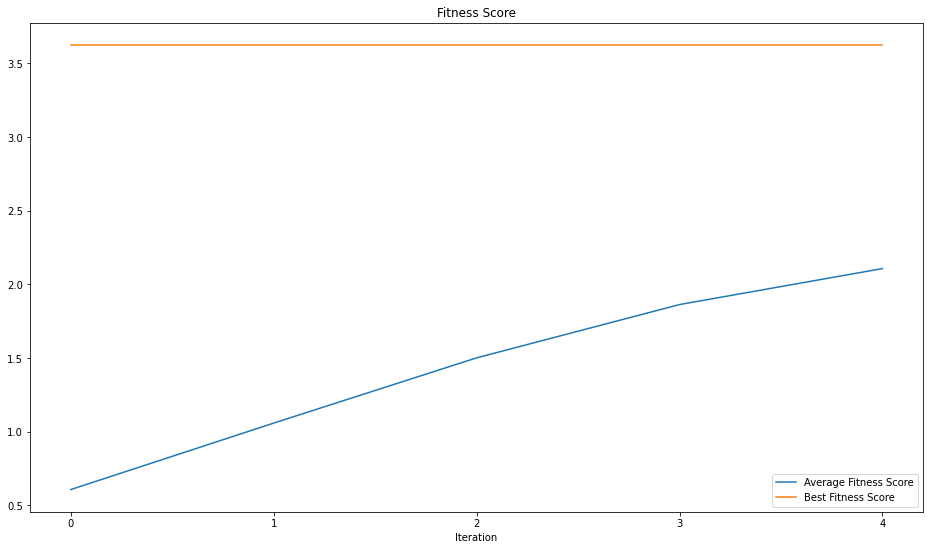

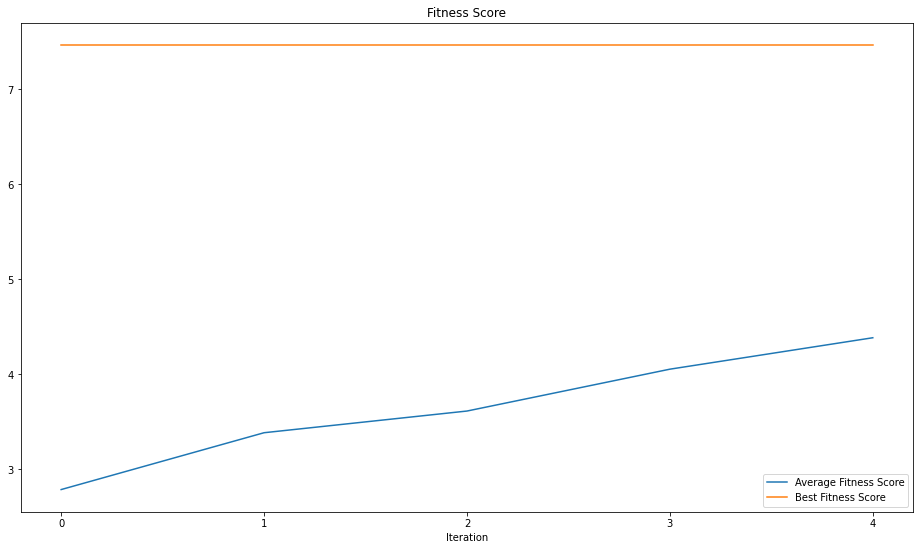

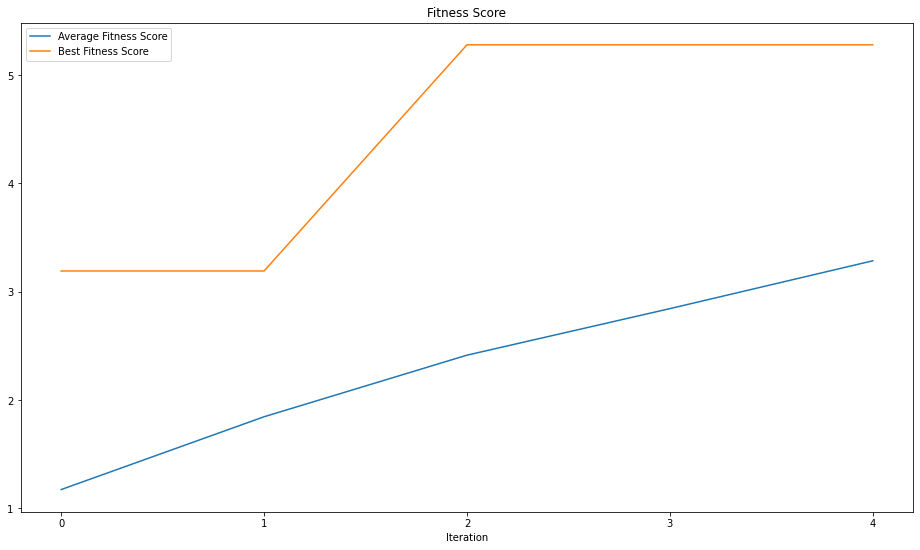

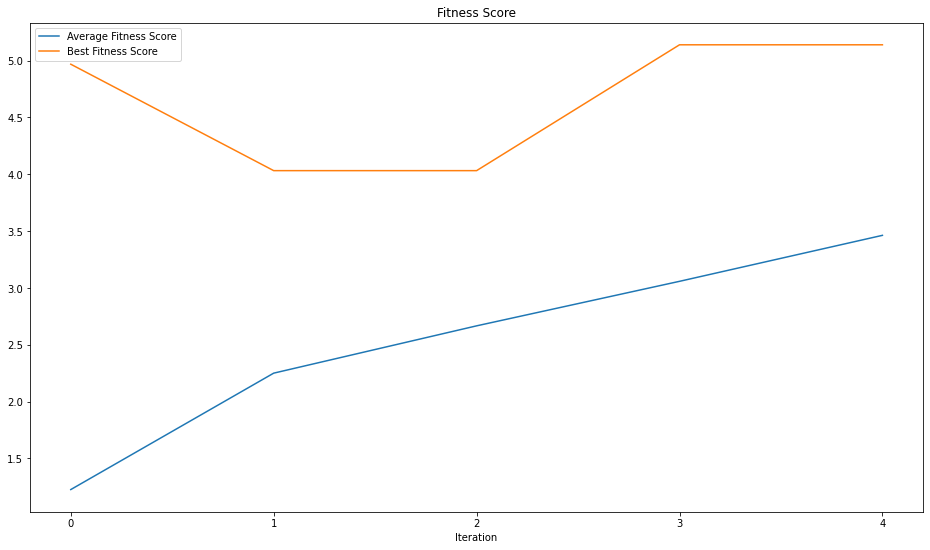

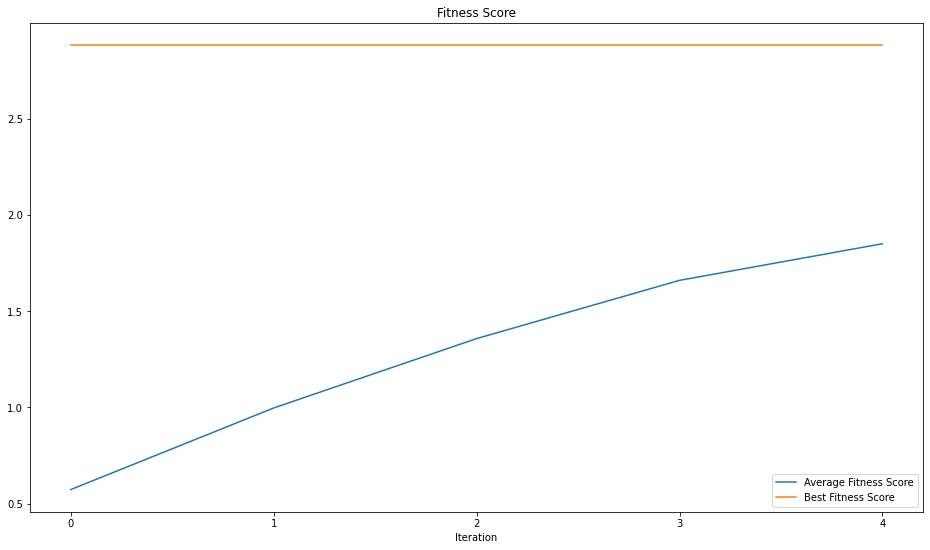

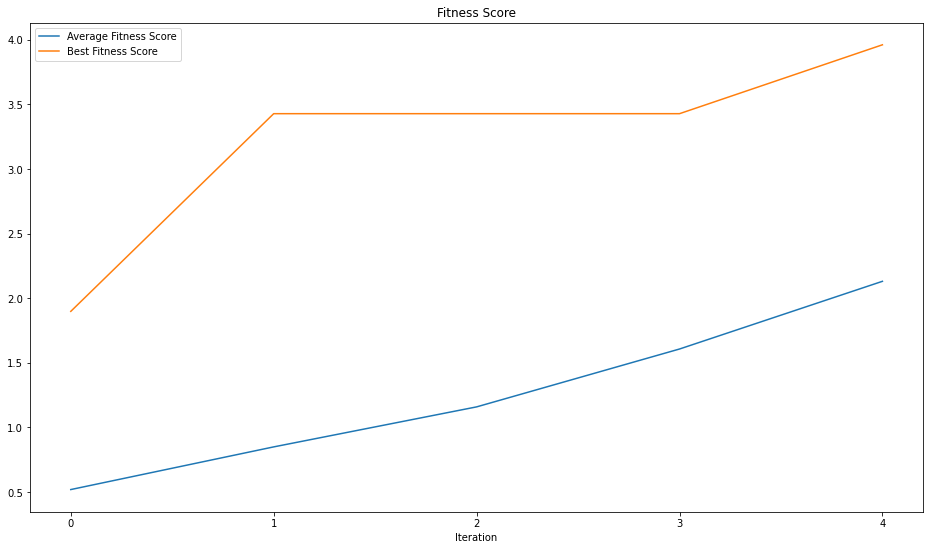

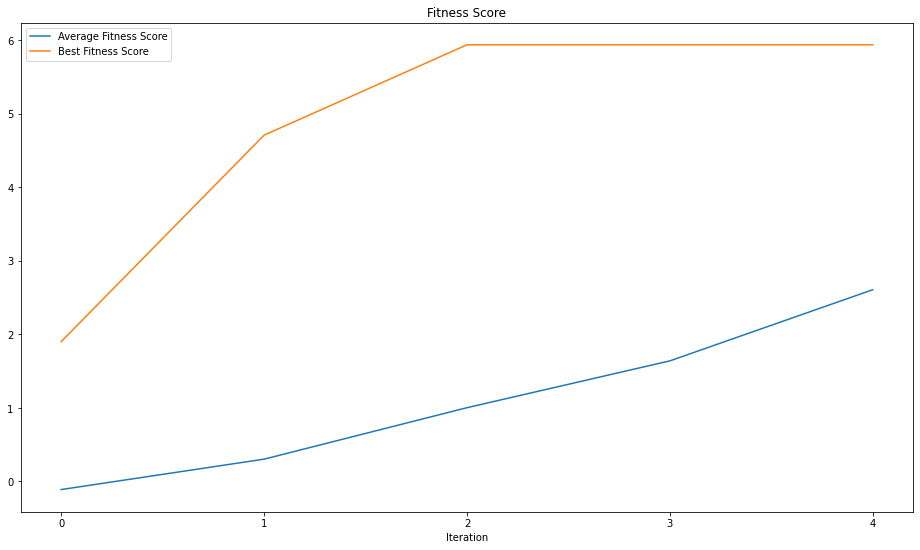

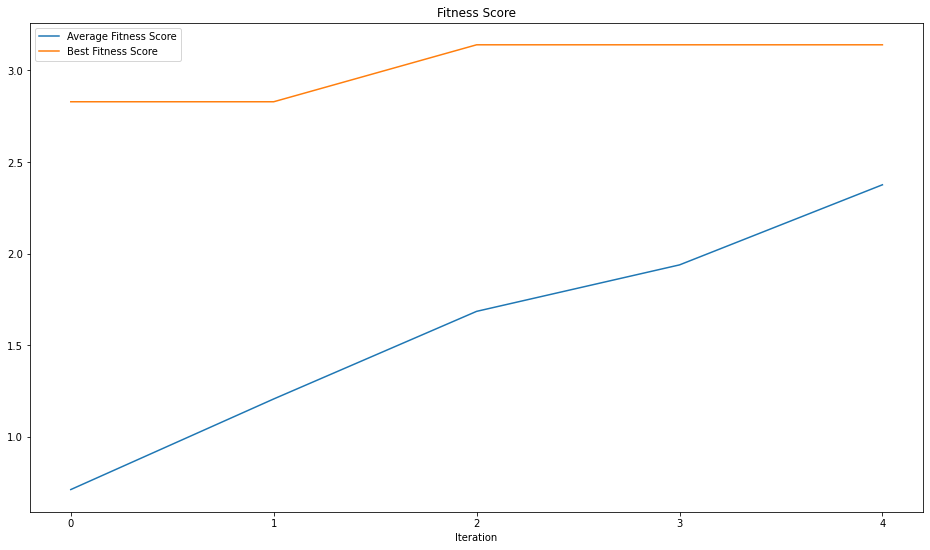

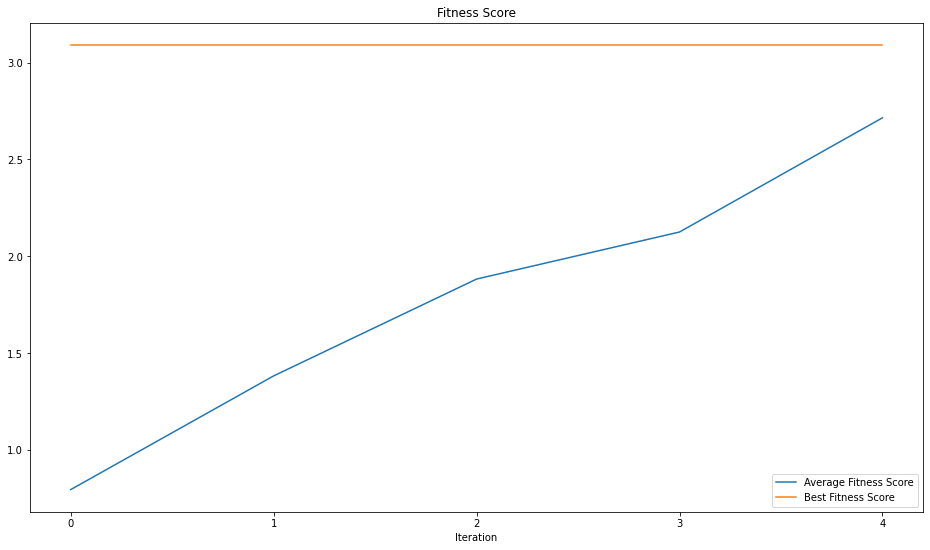

In [ ]:
for i in mktcap_code:  

  print(i)
  
  # backtest 데이터 가공

  data = pd.read_json(json_data[i], orient ='index') 
  df = data.transpose()

  #시간순 재정렬
  df = df.sort_values(by=['TRD_DD'])
  df.reset_index(drop=True,inplace=True)
  df['TRD_DD'] = pd.to_datetime(df['TRD_DD']) #datetime변환

  #인풋 데이터 모양 맞춰주기(backtest에 들어갈 데이터 모양)
  df_bt = df[['TRD_DD','TDD_OPNPRC','TDD_HGPRC','TDD_LWPRC','TDD_CLSPRC', 'ACC_TRDVOL']]
  df_bt['TRD_DD'] = pd.to_datetime(df_bt['TRD_DD'])
  df_bt.rename(columns={'TRD_DD':'Date', 'TDD_OPNPRC':'Open', 'TDD_HGPRC':'High','TDD_LWPRC':'Low','TDD_CLSPRC':'Close', 'ACC_TRDVOL':'Volume'}, inplace=True)
  df_bt.set_index('Date',drop=True,inplace=True)

  #데이터프레임 콤마(,) 제거 그리고 타입 소수로 변환
  df_bt['Open'] = df_bt['Open'].str.replace(',','').astype('float')
  df_bt['High'] = df_bt['High'].str.replace(',','').astype('float')
  df_bt['Low'] = df_bt['Low'].str.replace(',','').astype('float')
  df_bt['Close'] = df_bt['Close'].str.replace(',','').astype('float')
  df_bt['Volume'] = df_bt['Volume'].str.replace(',','').astype('float')

  class SmaCross1(bt.Strategy):
    params = dict(
      pfast=50, # period for the fast moving average
      pslow=200 # period for the slow moving average 
      ) 
    
    def __init__(self):
      sma1 = bt.ind.SMA(period = self.p.pfast) # fast moving average 
      sma2 = bt.ind.SMA(period = self.p.pslow) # slow moving average 
      self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 

    def next(self): 
      if not self.position: # not in the market 
        if self.crossover > 0: # if fast crosses slow to the upside 
          close = self.data.close[0] # 종가 값 
            
          size = int(self.broker.getcash() / close) # 최대 구매 가능 개수 
          self.buy(size=size) # 매수 size = 구매 개수 설정 
      elif self.crossover < 0: # in the market & cross to the downside 
          self.close() # 매도

  random.seed(3)

  PARAM_NAMES = ["pfast", "pslow"]

  NGEN = 5  # 알고리즘 5번 반복.
  NPOP = 100 #인구 초기
  CXPB = 0.5  #교차 전략 
  MUTPB = 0.3  #돌연변이 전략.


  #최소fintness 설정.(fitness값이 작을수록 좋도록 설정.)
  #creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
  #creator.create('Individual', list, fitness=creator.FitnessMin)

  creator.create("FitnessMax", base.Fitness, weights=(1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMax)

  def evaluate(individual, plot=False, log=False):

    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

    cerebro = bt.Cerebro(stdstats=False)

    data = bt.feeds.PandasData(dataname = df_bt, name = i)

    cerebro.adddata(data)

    initial_capital = 1000000
    cerebro.broker.setcash(initial_capital)

    cerebro.addstrategy(SmaCross1, **strategy_params)

    cerebro.addanalyzer(bt.analyzers.DrawDown)

    cerebro.broker.setcommission(commission=0.0025, margin=False)  #수수료 설정.

    strats = cerebro.run()

    profit = cerebro.broker.getvalue() - initial_capital

    max_dd = strats[0].analyzers.drawdown.get_analysis()["max"]["moneydown"] # max.moneydown - max drawdown value in monetary units
    fitness = profit / (max_dd if max_dd > 0 else 1)

    if log:
      print(f"Starting Portfolio Value: {initial_capital:,.2f}")
      print(f"Final Portfolio Value:  {cerebro.broker.getvalue():,.2f}")
      print(f"Total Profit:       {profit:,.2f}")
      print(f"Maximum Drawdown:     {max_dd:,.2f}")
      print(f"Profit / Max DD:     {fitness}")

    if plot:
      cerebro.plot()

    return [fitness]

  toolbox = base.Toolbox()
  toolbox.register("indices", random.sample, range(NPOP), NPOP)

  # crossover strategy
  toolbox.register("mate", tools.cxUniform, indpb=CXPB)
  # mutation strategy
  toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
  # selection strategy
  toolbox.register("select", tools.selTournament, tournsize=3)
  # fitness function
  toolbox.register("evaluate", evaluate)


  # definition of an individual & a population
  toolbox.register("attr_sma1", random.randint, 1, 100)
  toolbox.register("attr_sma2", random.randint, 151, 251) 
  toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
      toolbox.attr_sma1,
      toolbox.attr_sma2,

    ),
  )

  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  mean = np.ndarray(NGEN)
  best = np.ndarray(NGEN)
  hall_of_fame = tools.HallOfFame(maxsize=3)

  t = time.perf_counter()
  pop = toolbox.population(n=NPOP)
  for g in trange(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < CXPB:
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
      if random.random() < MUTPB:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
      "HALL OF FAME:\n"
      + "\n".join(
        [
          f"  {_}: {ind}, Fitness: {ind.fitness.values[0]}"
          for _, ind in enumerate(hall_of_fame)
        ]
      )
    )

    fitnesses = [
      ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)

  end_t = time.perf_counter()
  print(f"Time Elapsed: {end_t - t:,.2f}")

  fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

  sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
  sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
  ax.set_title("Fitness Score")
  ax.set_xticks(range(NGEN))
  ax.set_xlabel("Iteration")

  # plt.tight_layout()
  # plt.show()
  
  print('---------------------------------------------------------------------')
  print(i)
  OPTIMISED_STRATEGY_PARAMS = {
    k: v for k, v in zip(PARAM_NAMES, hall_of_fame[0])}
  print(OPTIMISED_STRATEGY_PARAMS)
  print('---------------------------------------------------------------------')

In [ ]:
-ind
# 소수점이 초과... 반올림해보자

# ----------------------------------------------------------------------------

In [ ]:
# 저장된 삼성전자(KR7005930003) 데이터 가져오기

# with open(data_path + 'initial_data1.json',"r") as json_file:
#     json_data = json.load(json_file) 

df = pd.read_json(json_data['KR7005930003'], orient ='index') 
samsung = df.transpose()
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2021/11/30,005930,삼성전자,"71,300","73,200","73,900","70,500","425,645,495,815,000","30,364,841","3,841",18.56,"39,406",1.81,"2,994",4.20
1,2021/11/29,005930,삼성전자,"72,300","71,700","73,000","71,400","431,615,278,365,000","16,682,559","3,841",18.82,"39,406",1.83,"2,994",4.14
2,2021/11/26,005930,삼성전자,"72,300","73,500","74,100","72,000","431,615,278,365,000","13,002,242","3,841",18.82,"39,406",1.83,"2,994",4.14
3,2021/11/25,005930,삼성전자,"73,700","75,100","75,100","73,600","439,972,973,935,000","12,559,258","3,841",19.19,"39,406",1.87,"2,994",4.06
4,2021/11/24,005930,삼성전자,"74,800","76,000","76,200","74,100","446,539,734,740,000","15,652,305","3,841",19.47,"39,406",1.90,"2,994",4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,1995/05/08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000","91,810",-,-,-,-,-,-
6729,1995/05/06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000","47,440",-,-,-,-,-,-
6730,1995/05/04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500","175,590",-,-,-,-,-,-
6731,1995/05/03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500","382,980",-,-,-,-,-,-


In [ ]:
#시간순 재정렬
samsung = samsung.sort_values(by=['TRD_DD'])
samsung.reset_index(drop=True,inplace=True)
samsung['TRD_DD']=pd.to_datetime(samsung['TRD_DD']) #datetime변환

In [ ]:
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL
0,1995-05-02,005930,삼성전자,"119,500","121,000","121,000","118,500","6,497,053,077,500",-,-,-,-,-,-,"139,560"
1,1995-05-03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500",-,-,-,-,-,-,"382,980"
2,1995-05-04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500",-,-,-,-,-,-,"175,590"
3,1995-05-06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000",-,-,-,-,-,-,"47,440"
4,1995-05-08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000",-,-,-,-,-,-,"91,810"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,2021-11-17,005930,삼성전자,"70,700","71,300","71,600","70,600","422,063,626,285,000","3,841",18.41,"39,406",1.79,"2,994",4.23,None
6724,2021-11-18,005930,삼성전자,"70,200","70,700","71,000","70,200","419,078,735,010,000","3,841",18.28,"39,406",1.78,"2,994",4.26,None
6725,2021-11-19,005930,삼성전자,"71,200","70,400","71,400","70,100","425,048,517,560,000","3,841",18.54,"39,406",1.81,"2,994",4.21,None
6726,2021-11-22,005930,삼성전자,"74,900","73,300","75,200","73,000","447,136,712,995,000","3,841",19.50,"39,406",1.90,"2,994",4.00,None


In [ ]:
#인풋 데이터 모양 맞춰주기(backtest에 들어갈 데이터 모양)
samsung_bt = samsung[['TRD_DD','TDD_OPNPRC','TDD_HGPRC','TDD_LWPRC','TDD_CLSPRC', 'ACC_TRDVOL']]
samsung_bt['TRD_DD'] = pd.to_datetime(samsung_bt['TRD_DD'])
samsung_bt.rename(columns={'TRD_DD':'Date', 'TDD_OPNPRC':'Open', 'TDD_HGPRC':'High','TDD_LWPRC':'Low','TDD_CLSPRC':'Close', 'ACC_TRDVOL':'Volume'}, inplace=True)
samsung_bt.set_index('Date',drop=True,inplace=True)
samsung_bt

#데이터프레임 콤마(,) 제거 그리고 타입 소수로 변환
samsung_bt['Open'] = samsung_bt['Open'].str.replace(',','').astype('float')
samsung_bt['High'] = samsung_bt['High'].str.replace(',','').astype('float')
samsung_bt['Low'] = samsung_bt['Low'].str.replace(',','').astype('float')
samsung_bt['Close'] = samsung_bt['Close'].str.replace(',','').astype('float')
samsung_bt['Volume'] = samsung_bt['Volume'].str.replace(',','').astype('float')
samsung_bt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Open,High,Low,Close,Volume
Date,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0
...,...,...,...,...,...
2021-11-17,71300.0,71600.0,70600.0,70700.0,NaN
2021-11-18,70700.0,71000.0,70200.0,70200.0,NaN
2021-11-19,70400.0,71400.0,70100.0,71200.0,NaN


In [ ]:
df = samsung_bt.copy()
df

,Open,High,Low,Close,Volume
Date,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0
...,...,...,...,...,...
2021-11-17,71300.0,71600.0,70600.0,70700.0,NaN
2021-11-18,70700.0,71000.0,70200.0,70200.0,NaN
2021-11-19,70400.0,71400.0,70100.0,71200.0,NaN


# backtest

In [ ]:
class SmaCross1(bt.Strategy):
  params = dict(
        pfast=50, # period for the fast moving average
        pslow=200 # period for the slow moving average 
        ) 
  
  def __init__(self):
    sma1 = bt.ind.SMA(period = self.p.pfast) # fast moving average 
    sma2 = bt.ind.SMA(period = self.p.pslow) # slow moving average 
    self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 

  def next(self): 
    if not self.position: # not in the market 
        if self.crossover > 0: # if fast crosses slow to the upside 
            close = self.data.close[0] # 종가 값 
                
            size = int(self.broker.getcash() / close) # 최대 구매 가능 개수 
            self.buy(size=size) # 매수 size = 구매 개수 설정 
    elif self.crossover < 0: # in the market & cross to the downside 
            self.close() # 매도



In [ ]:
# 세레브로 (벡트레이더 엔진) 설정

# 세레브로 가져오기
cerebro = bt.Cerebro()

# 데이터 가져오기
data = bt.feeds.PandasData(dataname=df,name="SAMSUNG")


# 데이터 추가하기
cerebro.adddata(data)

# 전략 추가하기
cerebro.addstrategy(SmaCross1)

# 브로커 설정
cerebro.broker.setcash (1000000)

# 매매 단위 설정
cerebro.addsizer(bt.sizers.SizerFix, stake = 30) #한번에 30주 설정.

최종금액 :  1369350.0 원
수익률 :  36.935 %




<IPython.core.display.Javascript object>

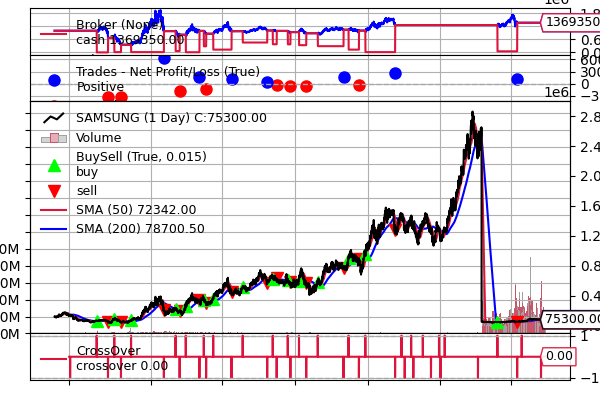

In [ ]:
# 3. 세레브로 실행하기

# 초기 투자금 가져오기
init_cash = cerebro.broker.getvalue()

# 세레브로 실행하기
cerebro.run()

# 최종 금액 가져오기
final_cash = cerebro.broker.getvalue()

print("최종금액 : ", final_cash, "원")
print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")
print("\n")

# # 차트 출력하기
# cerebro.plot()[0][0].savefig('plot.png', dpi=100)
# display(Image(filename='plot.png'))

# GA

In [ ]:
import random
import seaborn as sns
from tqdm import trange
import time

In [ ]:
random.seed(3)

PARAM_NAMES = ["pfast", "pslow"]

NGEN = 5   # 알고리즘 5번 반복.
NPOP = 100  #인구 초기
CXPB = 0.5   #교차 전략 
MUTPB = 0.3   #돌연변이 전략.


#최소fintness 설정.(fitness값이 작을수록 좋도록 설정.)
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#creator.create('Individual', list, fitness=creator.FitnessMin)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate(individual, plot=False, log=False):

  strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

  cerebro = bt.Cerebro(stdstats=False)
  cerebro.adddata(data)

  initial_capital = 1000000
  cerebro.broker.setcash(initial_capital)

  cerebro.addstrategy(SmaCross1, **strategy_params)

  cerebro.addanalyzer(bt.analyzers.DrawDown)

  cerebro.broker.setcommission(commission=0.0025, margin=False)   #수수료 설정.

  strats = cerebro.run()

  profit = cerebro.broker.getvalue() - initial_capital

  max_dd = strats[0].analyzers.drawdown.get_analysis()["max"]["moneydown"] # max.moneydown - max drawdown value in monetary units
  fitness = profit / (max_dd if max_dd > 0 else 1)

  if log:
    print(f"Starting Portfolio Value: {initial_capital:,.2f}")
    print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")
    print(f"Total Profit:             {profit:,.2f}")
    print(f"Maximum Drawdown:         {max_dd:,.2f}")
    print(f"Profit / Max DD:          {fitness}")

  if plot:
    cerebro.plot()

  return [fitness]

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(NPOP), NPOP)

# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# fitness function
toolbox.register("evaluate", evaluate)


# definition of an individual & a population
toolbox.register("attr_sma1", random.randint, 1, 100)
toolbox.register("attr_sma2", random.randint, 151, 251) 
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.attr_sma1,
        toolbox.attr_sma2,

    ),
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize=3)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)
for g in trange(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        "HALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)

end_t = time.perf_counter()
print(f"Time Elapsed: {end_t - t:,.2f}")

fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:08<16:33, 248.39s/it]

HALL OF FAME:
    0: [28, 129], Fitness: 2.9224001954215524
    1: [44, 238], Fitness: 2.6157614461194862
    2: [52, 156], Fitness: 2.286056377863675


 40%|████      | 2/5 [06:45<09:44, 194.77s/it]

HALL OF FAME:
    0: [44, 129], Fitness: 3.3223409564227664
    1: [35, 120], Fitness: 3.2742751092246887
    2: [50, 123], Fitness: 3.2472937763822753


 60%|██████    | 3/5 [09:20<05:53, 176.74s/it]

HALL OF FAME:
    0: [26, 129], Fitness: 4.482500069825293
    1: [35, 129], Fitness: 3.52497860318936
    2: [44, 129], Fitness: 3.3223409564227664


 80%|████████  | 4/5 [12:17<02:56, 176.71s/it]

HALL OF FAME:
    0: [26, 129], Fitness: 4.482500069825293
    1: [20, 129], Fitness: 3.8545397662732714
    2: [35, 129], Fitness: 3.52497860318936


100%|██████████| 5/5 [14:50<00:00, 178.08s/it]

HALL OF FAME:
    0: [26, 129], Fitness: 4.482500069825293
    1: [20, 129], Fitness: 3.8545397662732714
    2: [24, 156], Fitness: 3.726386378609074
Time Elapsed: 890.41


<IPython.core.display.Javascript object>

In [ ]:
OPTIMISED_STRATEGY_PARAMS = {
    k: v for k, v in zip(PARAM_NAMES, hall_of_fame[0])}
print(OPTIMISED_STRATEGY_PARAMS)

{'pfast': 26, 'pslow': 129}


최종금액 :  24554600.0 원
수익률 :  2355.46 %




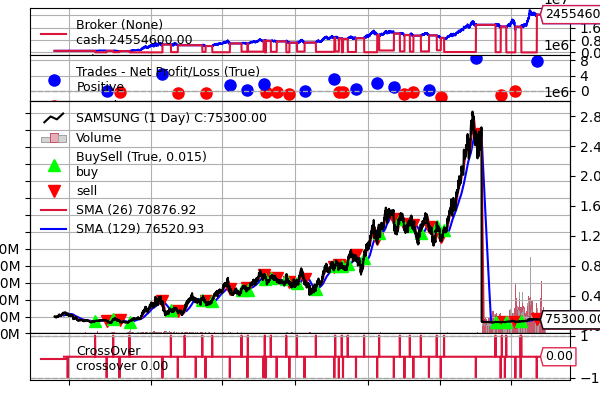

In [ ]:
# gdc

class SmaCross1(bt.Strategy):
  params = dict(
        pfast=26, # period for the fast moving average
        pslow=129 # period for the slow moving average 
        ) 
  
  def __init__(self):
    sma1 = bt.ind.SMA(period = self.p.pfast) # fast moving average 
    sma2 = bt.ind.SMA(period = self.p.pslow) # slow moving average 
    self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 

  def next(self): 
    if not self.position: # not in the market 
        if self.crossover > 0: # if fast crosses slow to the upside 
            close = self.data.close[0] # 종가 값 
                
            size = int(self.broker.getcash() / close) # 최대 구매 가능 개수 
            self.buy(size=size) # 매수 size = 구매 개수 설정 
    elif self.crossover < 0: # in the market & cross to the downside 
            self.close() # 매도




# 세레브로 (벡트레이더 엔진) 설정

#세레브로 가져오기
cerebro = bt.Cerebro()

#데이터 가져오기
data = bt.feeds.PandasData(dataname=df,name="SAMSUNG",openinterest=None)

#데이터 추가하기
cerebro.adddata(data)

#전략 추가하기
cerebro.addstrategy(SmaCross1)

#브로커 설정
cerebro.broker.setcash (1000000)

#매매 단위 설정
cerebro.addsizer(bt.sizers.SizerFix, stake = 30) #한번에 30주 설정.

# 3. 세레브로 실행하기

# 초기 투자금 가져오기
init_cash = cerebro.broker.getvalue()

# 세레브로 실행하기
cerebro.run()

# 최종 금액 가져오기
final_cash = cerebro.broker.getvalue()


print("최종금액 : ", final_cash, "원")
print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")
print("\n")

# 차트 출력하기
cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))